In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [324]:
df = pd.read_csv('../../plots/manuscript/SHAP/ShapConnections_aaron.csv')
df = df.groupby(['source','target'], as_index=False).mean()
df['value'] = df['value']*2
df['unique'] = df.apply(lambda x: True if x['source'] != x['target'] else False, axis=1)
df = df[df['unique'] == True]
print(df[df['target'] == 'Immune System'])

                                  source         target  Unnamed: 0     value  \
95                Adaptive Immune System  Immune System      3494.5  0.128632   
265  Cytokine Signaling in Immune system  Immune System      3670.5  0.124606   
819                 Innate Immune System  Immune System      3534.5  0.495084   

     type  source layer  target layer  unique  
95    0.5           3.0           4.0    True  
265   0.5           3.0           4.0    True  
819   0.5           3.0           4.0    True  


In [331]:
G = nx.DiGraph()

for k in df.iterrows():
    source = k[1]['source']
    value = k[1]['value']
    source_layer = k[1]['source layer']+1
    G.add_node(source, weight=value, layer=source_layer)
for k in df.iterrows():
    source = k[1]['source']
    target = k[1]['target']
    G.add_edge(source, target)
root_layer = max(df['target layer'])+1
G.add_node('root', weight=1, layer = root_layer)


In [332]:

def get_nearest_neighbors(G, query_node):
    SG = nx.Graph()
    G = G.to_undirected()
    for n in G.neighbors(query_node):
        SG.add_node(n, **G.nodes()[n])
        SG.add_edge(query_node, n)
    SG.add_node(query_node, **G.nodes()[query_node])
    return SG


In [357]:
def get_downstream_subgraph(G, query_node):
    SG = nx.Graph()
    nodes = [n for n in nx.traversal.bfs_successors(G, query_node) if n != query_node]
    for source, targets in nodes:
        SG.add_node(source, **G.nodes()[source])
        for t in targets:
            SG.add_node(t, **G.nodes()[t])
    for node1 in SG.nodes():
        for node2 in SG.nodes():
            if G.has_edge(node1,node2):
                SG.add_edge(node1,node2)
                
    SG.add_node(query_node, **G.nodes()[query_node])
    return SG

def get_upstream_subgraph(G, query_node):
    G = G.reverse()
    SG = get_downstream_subgraph(G, query_node)
    return SG
    
def get_complete_subgraph(G, query_node):
    SG = get_downstream_subgraph(G, query_node)
    G = G.reverse()
    nodes = [n for n in nx.traversal.bfs_successors(G, query_node) if n != query_node]
    for source, targets in nodes:
        SG.add_node(source, **G.nodes()[source])
        for t in targets:
            SG.add_node(t, **G.nodes()[t])
    for node1 in SG.nodes():
        for node2 in SG.nodes():
            if G.has_edge(node1,node2):
                SG.add_edge(node1,node2)
            
    SG.add_node(query_node, **G.nodes()[query_node])
    return SG


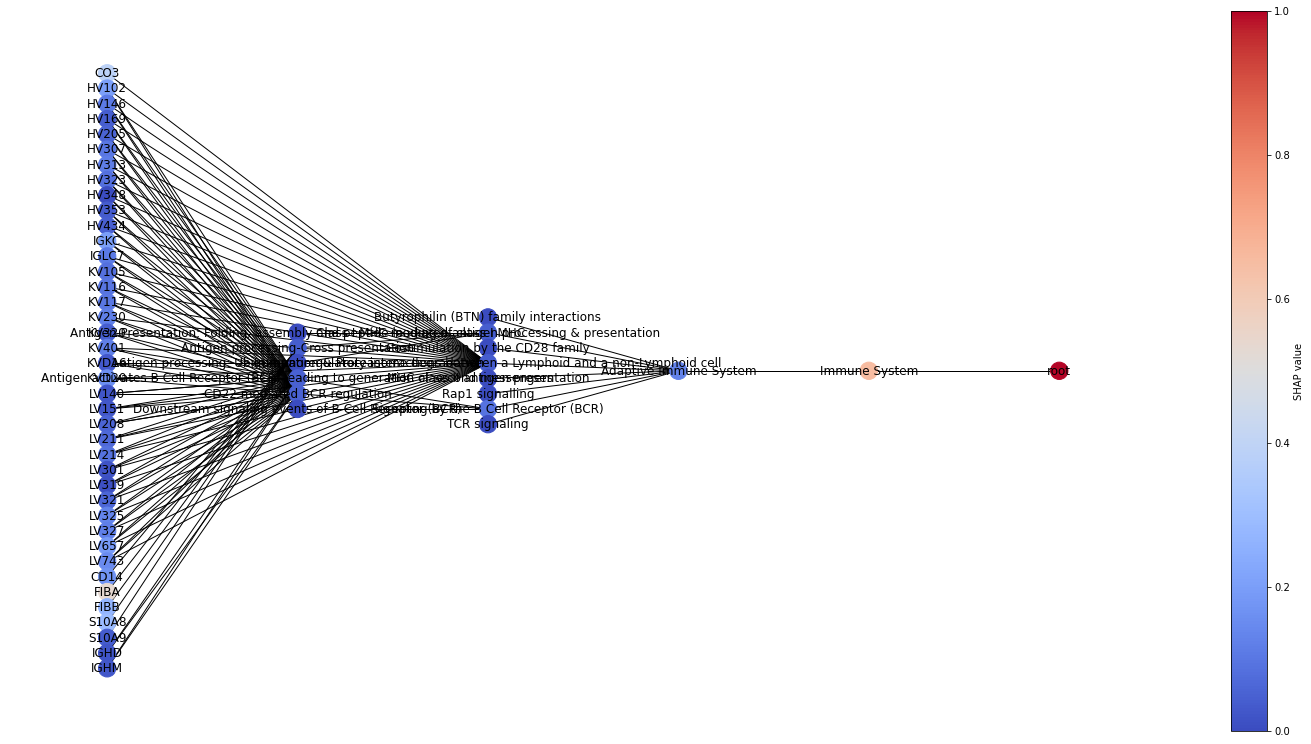

In [358]:

def draw(network):
    color = [network.nodes()[n]['weight'] for n in network.nodes()]
    pos = nx.multipartite_layout(network, subset_key="layer")
    plt.figure(figsize=(20,10))

    cmap = plt.cm.coolwarm

    nx.draw(network, pos, node_color=color, cmap=cmap, with_labels=True)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(color), vmax=max(color)))
    sm.set_array([])
    plt.colorbar(sm, label='SHAP value')
    
query_node = 'Adaptive Immune System'
SG = get_complete_subgraph(G, query_node)
draw(SG)